# Funds Simulation

In this notebook, we'll try to simulate funds. That way, we can try strategies for investment, and see how they work on the same data.

## Baseline (Random Walk)

For starters, we're going to use a basic random walk.

We make some assumptions there:

1. Past performance can't predict future performance
2. On average, the stock market increases by 10% a year.
3. It varies with a gaussian distribution (we know that's wrong, stocks vary a lot more)

In [4]:
using Distributions, StatsPlots, Plots

In [5]:
start_year = 2022

2022

I thought about using a normal distribution for the random walk, but it seems a Laplace distribution is a better choice ([source](https://seekingalpha.com/article/3959933-predicting-stock-market-returns-lose-normal-and-switch-to-laplace)). 

The author claims that the max returns he saw what +5.5% in one day. 

In [152]:
using CSV, DataFrames

In [163]:
sp_500 = CSV.read("s&p500_history.csv", DataFrame, header=[:year, :return_pct]);

In [165]:
sp_500[!,:return] = sp_500[!,:return_pct] ./ 100;

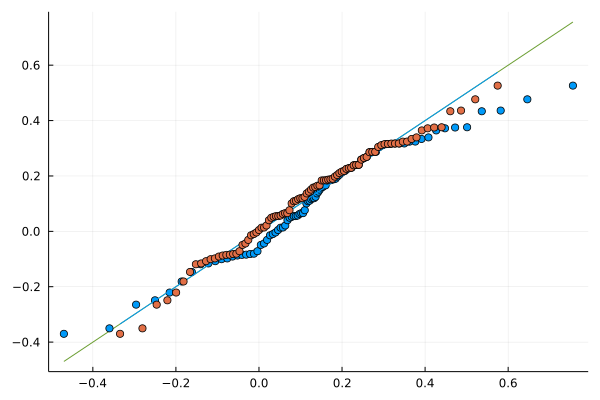

In [206]:
qqplot(Laplace, sp_500[!,:return])
qqplot!(Normal, sp_500[!,:return])

For yearly returns, the Laplace distribution over-estimates the good years a lot (right of the plot) and also over-estimates the bad ones (left of the plot). 

For daily returns, maybe it's a Laplace distribution. For yearly returns, the gaussian matches better the data (of course, this is the central value theorem!). So using a Laplace distribution might make sense for daily returns, but not for yearly ones.

In [210]:
δ_growth = fit(Normal, sp_500[!,:return])

Normal{Float64}(μ=0.12013814432989689, σ=0.19670320226707927)

In [211]:
function simulate(state, iterations, update_f)
    l = [state]
    last = state
    for i in 1:iterations
        new = update_f(last)
        append!(l, [new])
        last = new
    end
    return l
end

simulate (generic function with 1 method)

In [212]:
function year_ret(x)
    return x + rand(δ_growth)
end

year_ret (generic function with 1 method)

# Plotting Future Percentages

We plot the percentages in the future. Because we're talking about percentages, this is a logarithmic scale.

I think this is basically, if you put 1€ now, what you should have in ten years. So we don't consider saving regularly. 

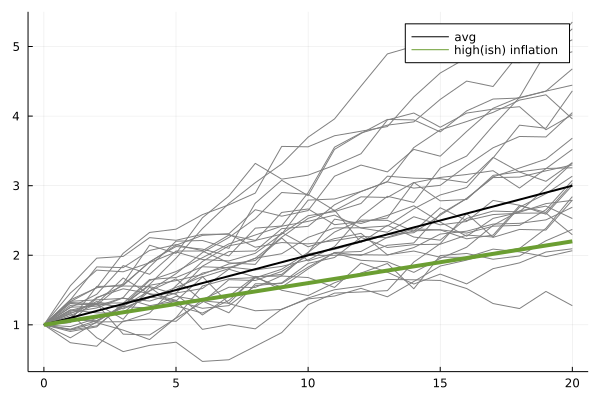

In [220]:
start = 1.0

n_years = 20

p = plot()
for i in 1:30
    values = simulate(start, n_years, year_ret)
    plot!(p, 0:n_years, values, label=missing, color="grey") 
end
plot!(p, x -> 1 + x * μ_growth , 
      w=2, label="avg", color="black")
p

# Worldwide inflation?
plot!(p, x -> 1 + x * 0.06, label="high(ish) inflation", w=4)

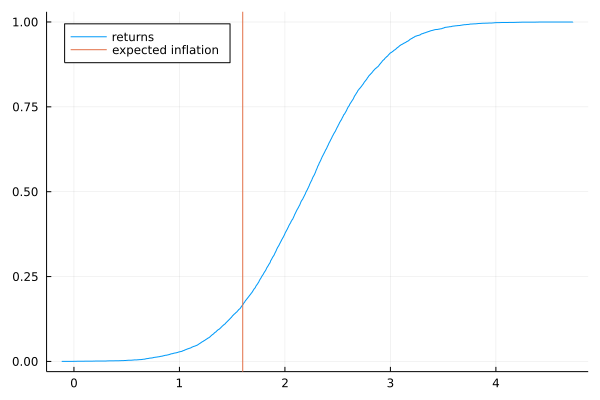

In [240]:
ten_year_values = [last(simulate(1.0, 10, year_ret)) for i in 1:10000]
    
inflation = last(simulate(1.0, 10, x -> x + 0.06))

ecdfplot(ten_year_values, label="returns")
vline!([inflation], label="expected inflation")

In [242]:
# Above inflation
count(x -> x > inflation, ten_year_values) / 10000 |> println
# Below inflation
count(x -> x <= inflation, ten_year_values) / 10000 |> println

0.8333
0.1667


## Possible Extensions

### Buying strategies

So far we've looked at one-time puchases. But usually, you save over many years. Some questions I have:

1. You can save regularly the same amount, and divide it among your funds. What is the best?
    a. Equal divide (1/n)
    b. Weight by past performance
    c. Weight by something else? (Size of countries involved, etc.)
2. Should you buy when the index goes:
    a. up? (If random walk, probably not!)
    b. down? (If random walk, probably yes)
3. What is the effect of funds fees on this? 
4. How to determine if a fund is worth the fee?

### Hierarchical Model

We know that funds have high correlation. To simulate this, we can estimate a "world economy" model as one random walk, and have "sub-regions" models, which vary around the main economy model (a little bit). The same could work for sectors (IT, consumer, etc.). 